# Imports

In [1]:
import numpy as np
import itertools as itt
import tensorflow as tf

import numpy.linalg as la

import scipy.stats as st
import numpy.random as rnd

import matplotlib.pyplot as pl
%matplotlib inline

from importlib import reload

import ipywidgets as ipw

In [2]:
from polys import Poly, PolyMesh, TaylorGrid
from pitf.tf_runnables import run_in_session

In [3]:
## changing the width of cells
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

Specify precision

In [4]:
floatX = np.float32

Open a new Tensorflow session for testing

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Auxilliary methods for working with batches

In [6]:
import polys.pi_batches as pib

In [7]:
def plot_batched_objects(objs, names = None, subplots_kwargs = {}):
    if names is None:
        names = [ "obj_" + str(i) for i, o in enumerate(objs) ]
       
    def fun(ii):
        print("batch_index =", ii)
        fig, axs = pl.subplots(nrows=1, ncols=len(objs), figsize= (5 * len(objs), 5), **subplots_kwargs)
        axs = np.array(axs, dtype = np.object)
        for name, obj, ax in zip(names, objs, axs.flat):
            pl.sca(ax)
            ax.set_title(name)
            obj.batch[ii].plot()
            
    pib.interact_along_batch(
        batch_shape = pib.get_common_broadcasted_shape([obj.batch_shape for obj in objs]), 
        display_fun = fun
    )

# Poly class - simple examples
#### 1D example

In [8]:
g = Poly(np.array([1, 2]))
g

Poly( [1 2] )

In [9]:
g * g

Poly( [1 4 4] )

In [10]:
## evaluate `g`
t = tf.Variable([1], dtype = floatX)
sess.run(t.initializer)

sess.run(g(t))

3.0

In [11]:
f = Poly(tf.constant([1, 0, 1], dtype = floatX))
run_in_session(f)

Poly( [1. 0. 1.] )

In [12]:
run_in_session([f*f, f*3, f + g, f + 3, f.truncate_degs(2), f.truncated_exp()])

[Poly( [1. 0. 2. 0. 1.] ),
 Poly( [3. 0. 3.] ),
 Poly( [2. 2. 1.] ),
 Poly( [4. 0. 1.] ),
 Poly( [1. 0.] ),
 Poly( [2.7182817 0.        2.7182817] )]

#### 2D example

In [13]:
# 2D example
f = Poly(rnd.randint(-3, 3, size = (10, 1, 6)), batch_ndim=1)
g = Poly(rnd.randint(-3, 3, size = (10, 2, 1)), batch_ndim=1)

In [14]:
pib.print_batched_objects(
    objs = [f, g, f * g, f + g, (f*g).truncate_degs(2), f.truncated_exp()], 
    names = ["f", "g",  "f * g", "f + g", "trunc(f*g)", "exp(f)"]
)

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

In [15]:
plot_batched_objects([f, g, f * g, f + g], names = ["f", "g",  "f * g", "f + g"], 
                     subplots_kwargs={"sharex": True, "sharey":True})

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

### Evaluation of Poly

In [16]:
x = tf.Variable([1, 2], name = "x", dtype = floatX)
sess.run(x.initializer)

In [17]:
## `f` is a batched polynomial, thus to evaluate every one at `x` 
## we need to add one batch-dimension also to `x`
f_x = f(x[None, :])

In [18]:
sess.run(f_x)

array([  15.,  -18.,  -16., -130.,  -65., -140.,  -33.,   80.,  -85.,
       -142.], dtype=float32)

# Other classes: `TaylorGrid`, `PolyMesh`

### Gaussian pdf

Generate batches of precision matrices `K` and means `mu`. You can choose `n` = 1 or 2.

In [19]:
n = 1
batch_ndim = 1
n_samples = 5000

def random_K():
    scaling = np.diag(rnd.uniform(0, 1 , size = n)) 
    phi = rnd.uniform(0, 2 * np.pi)
    if n == 2:
        rotation = np.array([
            [np.cos(phi), - np.sin(phi)], 
            [np.sin(phi), np.cos(phi)]
        ])
    else:
        rotation = np.array([[1]])
    return rotation @ scaling @ rotation.T
        
K = np.array([random_K() for i in range(n_samples)]).astype(floatX)

mu = rnd.randint(-1, 2, size = (n_samples, n)).astype(floatX)
params = [np.linspace(-4, 4, 20)]*n

If you wish, change them to Tensorflow objects

In [20]:
K = tf.Variable(K)
mu = tf.Variable(mu)

sess.run([K.initializer, mu.initializer])

[None, None]

Construct TaylorGrid taylors of Gauss PDF and the coresponding spline PolyMesh approximation

In [21]:
tg = TaylorGrid.from_Gauss_pdf(params, mu, K, batch_ndim, var_ndim= n)
spline0 = tg.get_spline()

In [22]:
spline = run_in_session(spline0)

In [23]:
spline.integrate()

array([0.9289181 , 0.9348461 , 0.99975973, ..., 0.99026567, 0.98563343,
       0.9780792 ], dtype=float32)

In [24]:
run_in_session(tg.integrate_spline())

array([0.9289181 , 0.9348461 , 0.9997598 , ..., 0.99026567, 0.9856334 ,
       0.97807914], dtype=float32)

In [25]:
run_in_session(spline0.integrate())

array([0.92891806, 0.9348461 , 0.9997597 , ..., 0.99026567, 0.9856334 ,
       0.9780791 ], dtype=float32)

In [26]:
%timeit run_in_session(spline0)

9.91 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
I1 = spline0.integrate()
I2 = tg.integrate_spline()

In [29]:
%timeit run_in_session(I1)

10.1 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit run_in_session(I2)

7.58 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


See the graphs of genuine PDF, our approximation and the approximation using Interpolators 

In [33]:
import interpolators_03 as interpolators

ModuleNotFoundError: No module named 'interpolators_03'

In [34]:
# if 2D use this visualization
def fun(ii):
    assert spline.var_ndim == 2, "This visualization works only in 2D case."
    f = spline.batch[ii]
    
    mu_val, K_val = run_in_session([mu, K])
    print("mu =" , mu_val[ii])
    print("K =" , K_val[ii])
    f0 = st.multivariate_normal(mean = mu_val[ii], cov = la.inv(K_val[ii])).pdf

    g = interpolators.Interpolator.from_fun(params, f0)

    xxx, yyy = [np.linspace(par[0], par[-1], 100) for par in params]

    fig, axs = pl.subplots(1, 3, figsize = [15, 4])
    for ax in axs:
        ax.set_aspect("equal")

    levels = None
    for fun, title, ax  in zip([g, f, f0], ["Catmull-Rom", "PolyMesh cubic spline", "genuine Gauss"], axs):
        pl.sca(ax)
        fff = np.array([[ fun([x,y]) for y in yyy ] for x in xxx]).T
        print(title, "minimum is", fff.min(), type(fun) )
        cp = pl.contour( xxx, yyy, fff, 
            cmap=pl.cm.rainbow,
            levels = levels
        )
        pl.clabel(cp)

        pl.scatter(*zip(*itt.product(*params)), marker = "+")

        ax.set_title(title)

        levels = cp.levels
        
pib.interact_along_batch(spline.batch_shape, fun )

interactive(children=(IntSlider(value=0, description='i0', max=4999), Output()), _dom_classes=('widget-interac…

In [35]:
# if 1D use this visualization
def fun(ii):
    assert spline.var_ndim == 1, "This visualization works only in 1D case."
    
    f = spline.batch[ii]
    
    mu_val, K_val = run_in_session([mu, K])
    print("mu =" , mu_val[ii])
    print("K =" , K_val[ii])
    f0 = st.multivariate_normal(mean = mu_val[ii], cov = la.inv(K_val[ii])).pdf
    g = interpolators.Interpolator.from_fun(params, f0)
    
    par = params[0]
    xxx = np.linspace(par[0], par[-1], 100)
    for fun, title in zip([g, f, f0], ["Catmull-Rom", "PolyMesh cubic spline", "genuine Gauss"]):
        yyy = [fun([x]) for x in xxx]
        pl.plot(xxx, yyy, label = title)
    
    pl.legend(fontsize = 'xx-small')
    
pib.interact_along_batch(spline.batch_shape, fun )

interactive(children=(IntSlider(value=0, description='i0', max=4999), Output()), _dom_classes=('widget-interac…

### Splines from given Taylors at grid points

A polynomial of high order that we approximate by a spline

In [28]:
f = Poly(np.array([1, -1, 4, 0,0, -3], dtype = floatX))

In [29]:
params = [np.array([0, 0.2, .5, 1], dtype=floatX)]
tg_f = f.get_Taylor_grid(params, truncs = 2)
spline_f = tg_f.get_spline()
plot_batched_objects(
    objs = [f, tg_f, spline_f], 
    names = ["original poly", "truncated Taylors at grid", "spline reconstruction"],
    subplots_kwargs={"sharex": True, "sharey":True}
)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

### Evaluation of MeshGrid at TF points

In [30]:
spline_f(np.array([1.2]))

-1.6579999999999995

In [31]:
t

<tf.Variable 'Variable:0' shape=(1,) dtype=float32_ref>

In [32]:
sess.run(
    spline_f(t), {t: [1.2]}
)

-1.658001

### Catmull-Rom splines

#### Example CR-01

In [33]:
xx = np.array([1, 2, 3, 4, 5])

yy = tf.Variable([[1, 2, 0, 1, 1]], dtype=floatX, validate_shape=False)
yy.set_shape([None, len(xx)])

taylors = TaylorGrid.from_Catmull_Rom(yy, params = [xx], batch_ndim=1)
spline = taylors.get_spline()

In [34]:
sess.run(tf.global_variables_initializer())

taylors_val, spline_val, yy_val = run_in_session(
    [taylors, spline, yy],
    feed_dict = {
        yy: rnd.randint(10, size = [10, len(xx)]).astype(floatX)
    }
)

In [35]:
def fun(iii):
    taylors_val.batch[iii].plot(c = "g")
    pl.scatter(xx, yy_val[iii])
    spline_val.batch[iii].plot(c = "b")
    

pib.interact_along_batch(batch_shape=spline_val.batch_shape, display_fun=fun)

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

#### Example CR-02

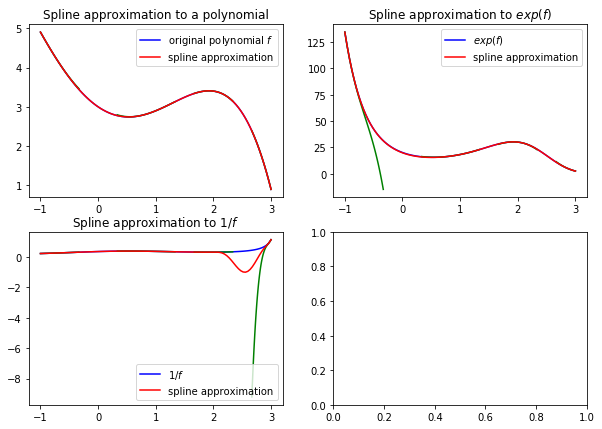

In [36]:
fig, axs = pl.subplots(2, 2, figsize = [10, 7])
axs = axs.flat

ax = axs[0]
pl.sca(ax)
ax.set_title("Spline approximation to a polynomial")

f = Poly(np.array([3, -1, 1, 0, -0.1]))

pg = f.get_Taylor_grid([[-1, 1, 2, 3]], truncs = 4)
a, b = pg.params[0][0], pg.params[0][-1]
f.plot([a], [b], c = "b", label= "original polynomial $f$")

pg.plot(c = "g")

pm = pg.get_spline()
pm.plot(c = "r", label = "spline approximation")

ax.legend()

## exponential
ax = axs[1]
pl.sca(ax)
ax.set_title("Spline approximation to $exp(f)$")

xxx = np.linspace(a, b, 100)
yyy = np.exp(f.batch[None](xxx[:, None]))
pl.plot(xxx, yyy, c = "b", label= "$exp(f)$")

pg.truncated_exp().plot(c = "g")

pg.truncated_exp().get_spline().plot(c = "r", label = "spline approximation")
ax.legend()

## inverse
ax = axs[2]
pl.sca(ax)
ax.set_title("Spline approximation to $ 1 / f$")

xxx = np.linspace(a, b, 100)
yyy = 1 / (f.batch[None](xxx[:, None]))
pl.plot(xxx, yyy, c = "b", label= "$1/f$")

(1 / pg).plot(c = "g")

(1 / pg).get_spline().plot(c = "r", label = "spline approximation")
ax.legend(loc = 4)



#### Example CR-03

Original polynomial (class `Poly`)

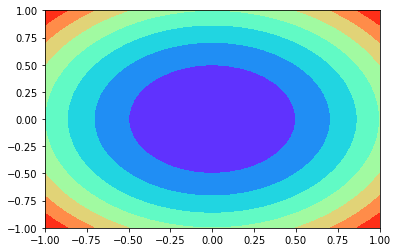

In [37]:
f = Poly(
    np.array([
        [1, 0, 1],
        [0, 0, 0],
        [1, 0, 0],
    ], dtype = floatX)
)
f([0.1, 0.2])
f.plot([-1,-1], [1, 1])

Its Taylor polynomials at specified grid points (class `TaylorGrid`)

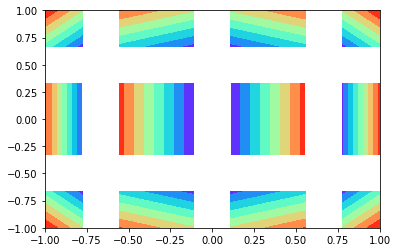

In [38]:
pg = f.get_Taylor_grid([[-1, -1/3, 1/3, 1], [-1, 0, 1]], truncs = 2)
pg.plot()
#f.plot([par[0] for par in pg.params], [par[-1] for par in pg.params])

Spline reconstruction (class `PolyMesh`)

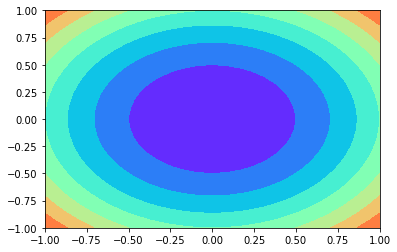

In [39]:
pm = pg.get_spline()
pm.plot()
#pm.contour_plot(levels = np.linspace(-1, 1, 15))

## `PolyMesh` operations

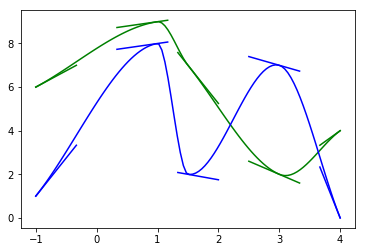

In [41]:
xx = np.array([-1, 1, 1.5, 3, 4])

f_tg, g_tg = [
    TaylorGrid.from_Catmull_Rom(
        coef = rnd.randint(10, size = [len(xx)]).astype(floatX), 
        params = [xx], 
    )
    for i in range(2)
]

f_pm, g_pm = [tg.get_spline() for tg in [f_tg, g_tg]]

#fig, axs = pl.subplots(1, 2, figsize = [10, 4])

f_pm.plot(c = "g")
f_tg.plot(c = "g")
g_pm.plot(c = "b")
g_tg.plot(c = "b")


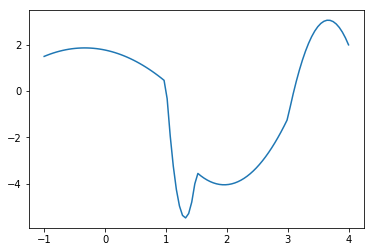

In [42]:
f_pm.der().plot()

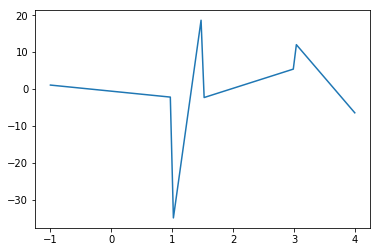

In [43]:
f_pm.der().der().plot()

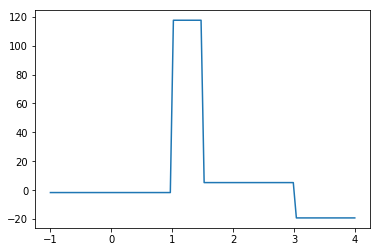

In [44]:
f_pm.der().der().der().plot()

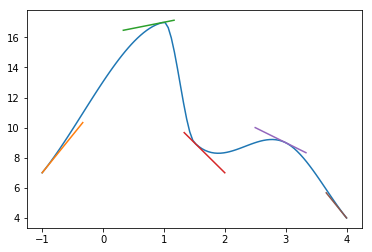

In [45]:
(f_pm + g_pm).plot()
(f_tg + g_tg).plot()

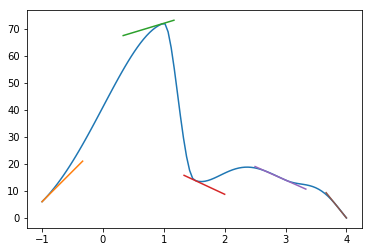

In [46]:
(f_pm * g_pm).plot()
(f_tg * g_tg).plot()

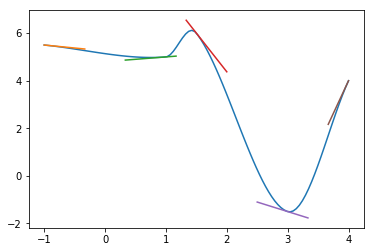

In [47]:
(f_pm - g_pm /2).plot()
(f_tg - g_tg /2).plot()

#### Test derivatives
Derivative of $x^2$ represented as `PolyMesh`.

In [48]:
p = Poly(np.array([0, 0, 1], dtype = floatX))
h_tg = p.get_Taylor_grid(params = [xx], truncs = 2)

In [49]:
h_pm = h_tg.get_spline()

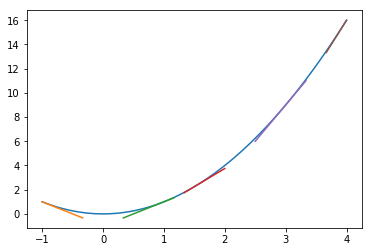

In [50]:
h_pm.plot()
h_tg.plot()

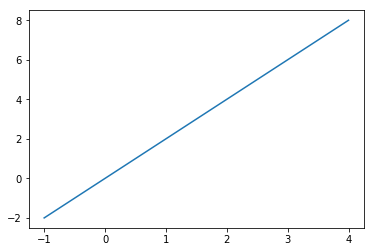

In [51]:
h_pm.der().plot()

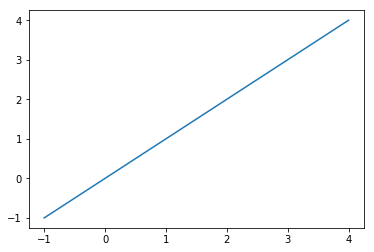

In [52]:
x_pm = h_pm.der() / 2
x_pm.plot()

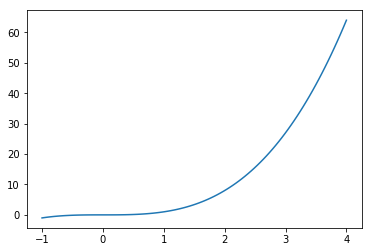

In [53]:
(x_pm * x_pm* x_pm).plot()

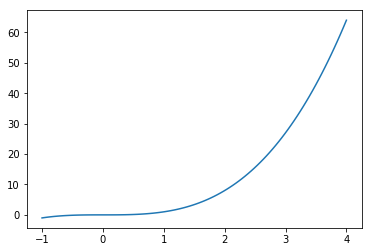

In [54]:
(x_pm ** 3).plot()